# Risk and Behavior Modeling
This project is to build a risk analysis and report generator for transactions in banks, the dataset is publicily available and well documented as is from the recently published [AMLNet dataset](https://arxiv.org/html/2509.11595). Information of the dataset is found in [zenodo](https://zenodo.org/records/16482144)

CORE TRANSACTION DATA:
- step: Sequential transaction step/ID
- type: Payment method (TRANSFER, OSKO, BPAY, EFTPOS, DEBIT, NPP)
- amount: Transaction amount in AUD (positive/negative values)
- category: Transaction category (Housing, Food, Transport, Recreation, Other)
- nameOrig: Originating customer ID (e.g., C3511)
- nameDest: Destination customer/merchant ID (e.g., C4945, M558)
- oldbalanceOrg: Account balance before transaction
- newbalanceOrig: Account balance after transaction

LABELS:
- isFraud: Binary fraud indicator (0=legitimate, 1=fraudulent)
- isMoneyLaundering: Binary AML label (0=normal, 1=suspicious)
- fraud_probability: Calculated fraud risk score

TEMPORAL FEATURES:
- hour: Hour of transaction (0-23)
- day_of_week: Day of week (1=Monday, 7=Sunday)
- day_of_month: Day of month (1-31)
- month: Month number (1-12)

METADATA:
- metadata: JSON object containing:
  * timestamp: Exact transaction datetime
  * location: City, state, country, postcode
  * device_info: Device type, OS, IP address
  * payment_method: Specific payment method used
  * merchant_info: Merchant details (if applicable)
  * risk_indicators: Comprehensive risk scoring metrics

In [101]:
# System management
import time, psutil
from pathlib import Path, PurePath
import joblib
from typing import Dict, List

# Math & Data
import numpy as np
import pandas as pd
from scipy.stats import chi2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.contrib import itertools

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In statistics and data analysis, an anomaly or outlier refers to a rare observation which deviates significantly from the majority of the data and does not conform to a well-defined notion of normal behaviour.

We start by reading the dataset

In [102]:
path = PurePath("../dataset/AMLNet_Dataset.csv")
df = pd.read_csv(path)
df.head(5)

,step,type,amount,category,nameOrig,nameDest,oldbalanceOrg,newbalanceOrig,isFraud,isMoneyLaundering,laundering_typology,metadata,fraud_probability,hour,day_of_week,day_of_month,month
0,0,DEBIT,298.842041,Other,C8083,C7053,455489.321571,455190.479531,0,0,normal,"{'timestamp': datetime.datetime(2025, 2, 4, 12...",NaN,12,1,4,2
1,0,DEBIT,93.087916,Recreation,C5575,C1117,229508.291214,229415.203298,0,0,normal,"{'timestamp': datetime.datetime(2025, 2, 4, 12...",NaN,12,1,4,2
2,0,EFTPOS,155.644864,Healthcare,C1549,C1423,202568.806856,202413.161992,0,0,normal,"{'timestamp': datetime.datetime(2025, 2, 4, 12...",NaN,12,1,4,2
3,0,BPAY,299.759073,Food,C7435,C6390,491560.600203,491260.841131,0,0,normal,"{'timestamp': datetime.datetime(2025, 2, 4, 12...",NaN,12,1,4,2
4,0,DEBIT,173.715615,Other,C8083,C5946,455190.479531,455016.763916,0,0,normal,"{'timestamp': datetime.datetime(2025, 2, 4, 12...",NaN,12,1,4,2


In [103]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,1090172.0,0.000406,0.040688,0.000000,0.000000,0.000000,0.000000,7.000000
amount,1090172.0,654.622792,1336.994731,12.521305,108.204016,172.514891,385.274978,204941.214692
oldbalanceOrg,1090172.0,303653.905860,94172.470768,37.168991,228604.424283,305230.013995,380033.687735,520513.550672
newbalanceOrig,1090172.0,302999.283068,94189.050710,1.406325,227967.666776,304581.159330,379391.892163,499400.531898
isFraud,1090172.0,0.001601,0.039976,0.000000,0.000000,0.000000,0.000000,1.000000
isMoneyLaundering,1090172.0,0.001601,0.039976,0.000000,0.000000,0.000000,0.000000,1.000000
fraud_probability,1080000.0,0.025715,0.035122,0.000000,0.000000,0.000000,0.050000,1.000000
hour,1090172.0,11.493727,6.911962,0.000000,5.000000,11.000000,17.000000,23.000000
day_of_week,1090172.0,2.313389,1.785314,0.000000,1.000000,2.000000,4.000000,6.000000
day_of_month,1090172.0,15.672022,8.730335,1.000000,8.000000,16.000000,23.000000,31.000000


As stated in the paper, the dataset contains information across 195 days.

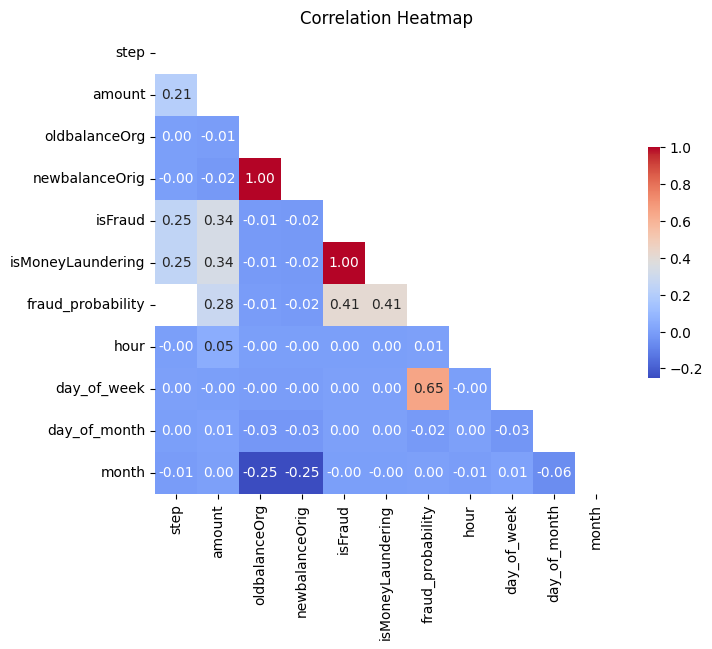

In [104]:
corr_matrix = df.select_dtypes(include='number').corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap")
plt.show()

- The amount is correlated with the fraud probability, as we may expect a high amout is not completely legal in some sense
- Is interesting to see that the day of the week is also correlated with the fraud probability
- New balance is negatively corelated to the month, this is expected due to that in some months one makes more money

Time and money are the most important concepts to detect fraudulent activities 

Memory usage: 968.81 MB
Dataset shape: 1090172 rows, 17 columns
Distribution of isFraud class:
  Authentic: 1,088,427 (99.84%)
  Fraud:     1,745 (0.16%)


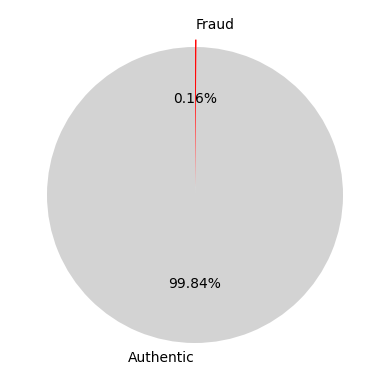

In [105]:
def data_details(
        data: pd.DataFrame,
        targets: list[str] 
    ):
    memory = data.memory_usage(deep=True).sum() / 1024**2  
    shape = data.shape

    print(f"Memory usage: {memory:.2f} MB")
    print(f"Dataset shape: {shape[0]} rows, {shape[1]} columns")
    
    for tar in targets:
        # Class distribution
        print(f"Distribution of {tar} class:")
        no_frauds = data[data[tar] == 0] 
        frauds = data[data[tar] == 1]
        
        counts = [len(no_frauds), len(frauds)]
        percentages = [count/len(data)*100 for count in counts]
        labels = ['Authentic', 'Fraud']
        
        print(f"  Authentic: {counts[0]:,} ({percentages[0]:.2f}%)")
        print(f"  Fraud:     {counts[1]:,} ({percentages[1]:.2f}%)")
        
        # Pie chart
        fig, ax = plt.subplots(figsize=(4, 4))
        _ = ax.pie(
            counts, 
            labels=labels, 
            colors=['lightgrey', 'red'],
            autopct='%1.2f%%',
            startangle=90,
            explode=(0, 0.05) 
        )
        plt.tight_layout()
        plt.show()
# We can omit the `isMoneyLaundering` col as it has the same distribution 
data_details(df, ['isFraud'])

This is a typical observation in real world data. Fraudulent cases are very rare, so is in this dataset,

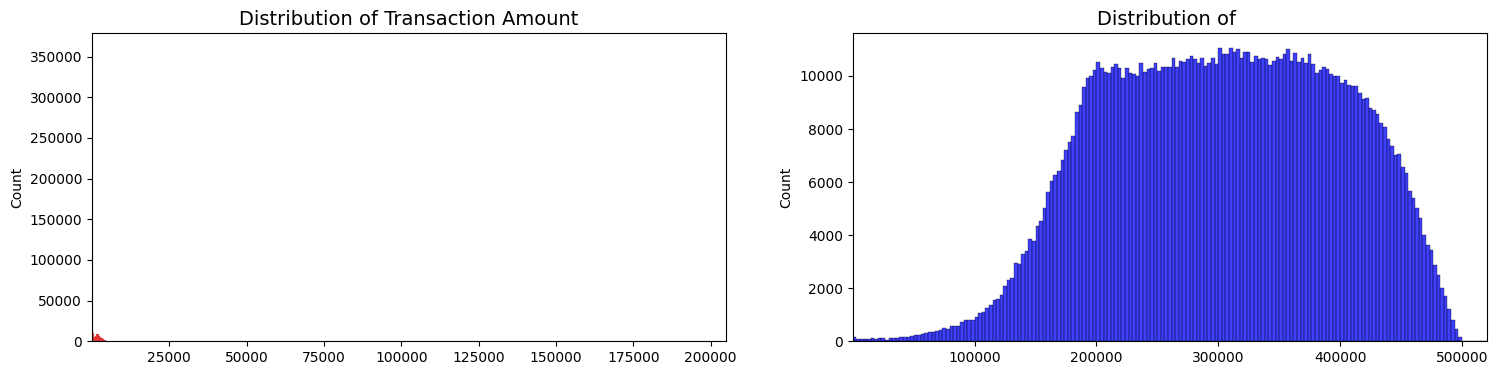

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['amount'].values
time_val = df['oldbalanceOrg'].values

sns.histplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.histplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of ', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

# Feature Selection
From Thudumu et al. (2020):

> High dimensionality creates difficulties for anomaly detection because, when the number of attributes or features increase, the amount of data needed to generalize accurately also grows, resulting in data sparsity in which data points are more scattered and isolated. This data sparsity is due to unnecessary variables, or the high noise level of multiple irrelevant attributes, that conceal the true anomalies. This issue is widely acknowledged as the curse of dimensionality.

We do have a lot of information in this dataset. However, using information that does not help us determine if the transaction is fraudulent or not may make things slower, so in this section we are going to distil information 

In [107]:
# The isMoneyLaundering column has the same locations that the isFraud column, no needing to keep it we can drop it
df.drop(
    ['isMoneyLaundering', 'step'],
    axis=1,
    inplace=True
)

Now to the next steps


C:\Users\super\AppData\Local\Temp\ipykernel_24248\2330520024.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i // ncols, i % ncols].legend()


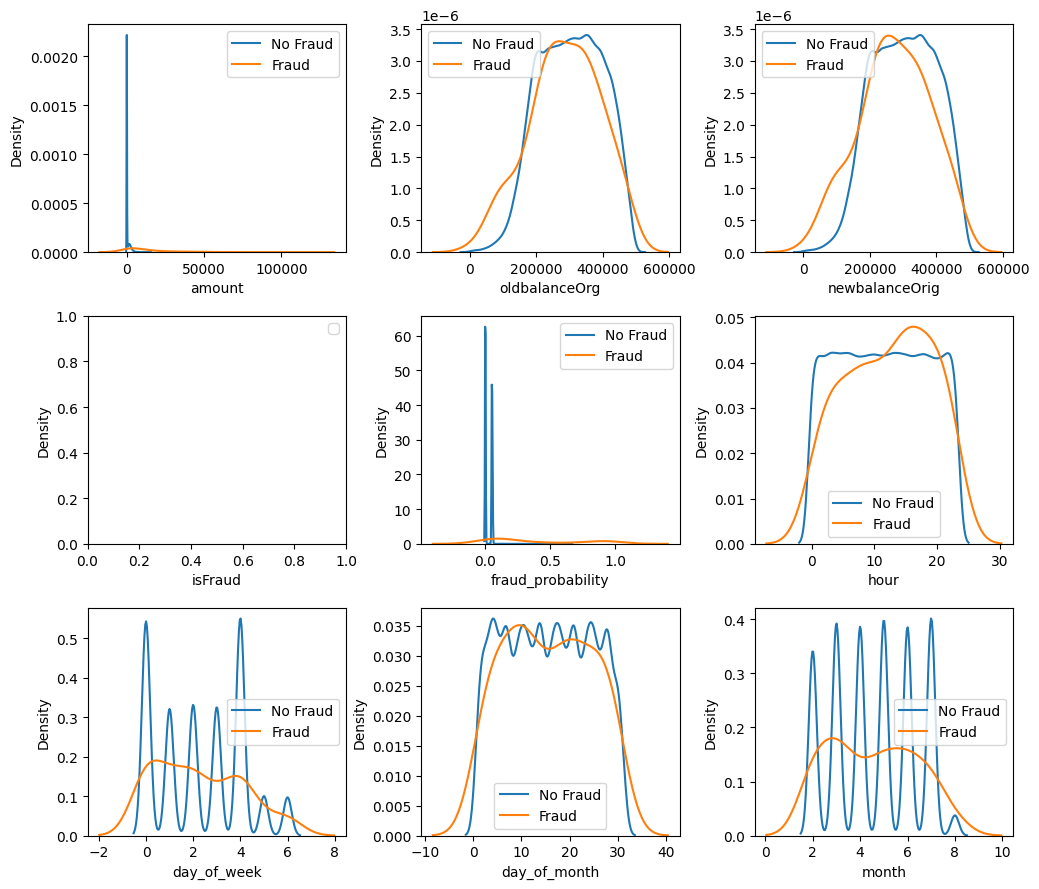

In [108]:
def feature_selection(df: pd.DataFrame, seed: int = 17):

    num_df = df.select_dtypes('number')
    sample = num_df.sample(frac=0.1, random_state=seed)

    data_val_0 = sample[sample['isFraud'] == 0]
    data_val_1 = sample[sample['isFraud'] == 1]

    cols = list(sample.columns)
    ncols = 3
    nrows = int(np.ceil(len(cols) / ncols))

    fig, ax = plt.subplots(
        nrows, ncols,
        figsize=(3.5 * ncols, 3 * nrows),
        squeeze=False
    )

    for i, col in enumerate(cols):
        sns.kdeplot(data_val_0[col], ax = ax[i // ncols, i % ncols], label='No Fraud', warn_singular=False)
        sns.kdeplot(data_val_1[col], ax = ax[i // ncols, i % ncols], label='Fraud', warn_singular=False)
        ax[i // ncols, i % ncols].legend()
        
    plt.tight_layout()
    plt.show()


feature_selection(df)

We will drop the metadata column, as I want the LLM to focus only on __behavioral patterns__, using metadata would force the LLM to reason a bit more using device/location details which being honest are very important. But due to computational limitations and also to keep the model simple, I will neglect the use of this information (maybe I use it in other work).


In [109]:
metadata_sample = df.metadata[0]
from pprint import pp
pp(metadata_sample)

("{'timestamp': datetime.datetime(2025, 2, 4, 12, 22, 36, 770518), 'location': "
 "{'city': 'Sydney', 'state': 'NSW', 'country': 'Australia', 'postcode': "
 "'2755'}, 'device_info': {'type': 'Mobile', 'os': 'Windows', 'ip_address': "
 "'109.75.48.170'}, 'payment_method': 'BSB_Account', 'merchant_info': None, "
 "'risk_indicators': {'amount_vs_average': 2.403414656867827, "
 "'customer_risk_score': 100, 'category_risk': 'medium', 'risk_score': "
 "66.30275436133387, 'unusual_time': False, 'unusual_location': False}}")


## Objective
The objective of the project is to detect anomalies in transactions.

In [110]:
class GaussianAnomalyPreprocessor:
    """
    Feature engineering pipeline optimized for Gaussian-based anomaly models
    (GMM, Mahalanobis distance, Gaussian ensembles).
    """
    BASE_COLS = [
        'nameOrig',
        'amount',
        'category',
        'hour',
        'day_of_week',
        'month'
    ]
    GAUSSIAN_FEATURES = [
        'log_amount',
        'amount_zscore',
        'hour_sin', 'hour_cos',
        'hour_diff',
        'is_weekend',
        'category_freq',
        'category_match',
        'log_customer_tx_count',
        'customer_avg_amount'
    ]

    def __init__(self):
        self.scaler = RobustScaler()
        self.category_freq_ = None
        self.customer_stats_ = None

    # ----------------------------
    # FIT
    # ----------------------------
    def fit(self, df: pd.DataFrame):
        df = df[self.BASE_COLS].copy()

        # Category frequency (global, stable)
        self.category_freq_ = df['category'].value_counts(normalize=True)

        # Customer statistics (fit-time ONLY → no leakage)
        customer_stats = df.groupby('nameOrig').agg(
            customer_avg_amount=('amount', 'mean'),
            customer_std_amount=('amount', 'std'),
            customer_tx_count=('amount', 'count'),
            customer_avg_hour=('hour', 'mean'),
            customer_pref_category=('category', lambda x: x.mode().iloc[0])
        )

        customer_stats['customer_std_amount'] = customer_stats['customer_std_amount'].fillna(0.0)

        self.customer_stats_ = customer_stats

        # Fit scaler on final Gaussian features
        X = self._build_features(df)
        self.scaler.fit(X[self.GAUSSIAN_FEATURES])

        return self

    # ----------------------------
    # TRANSFORM
    # ----------------------------
    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        if self.category_freq_ is None or self.customer_stats_ is None:
            raise RuntimeError("Preprocessor must be fitted before calling transform().")

        df = df[self.BASE_COLS].copy()
        X = self._build_features(df)

        X_scaled = self.scaler.transform(X[self.GAUSSIAN_FEATURES])
        X_scaled = pd.DataFrame(
            X_scaled,
            columns=self.GAUSSIAN_FEATURES,
            index=df.index
        )

        return X_scaled

    # ----------------------------
    # INTERNAL FEATURE ENGINEERING
    # ----------------------------
    def _build_features(self, df: pd.DataFrame) -> pd.DataFrame:

        # Merge customer stats
        df = df.merge(
            self.customer_stats_,
            on='nameOrig',
            how='left'
        )

        # ----- Amount -----
        df['log_amount'] = np.log1p(df['amount'])
        df['amount_zscore'] = (
            (df['amount'] - df['customer_avg_amount']) /
            (df['customer_std_amount'] + 0.01)
        )

        # ----- Time -----
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['hour_diff'] = np.abs(df['hour'] - df['customer_avg_hour'])
        df['is_weekend'] = (df['day_of_week'] >= 6).astype(int)

        # ----- Category -----
        df['category_freq'] = df['category'].map(self.category_freq_).fillna(0)
        df['category_match'] = (
            df['category'] == df['customer_pref_category']
        ).astype(int)

        # ----- Customer stability -----
        df['log_customer_tx_count'] = np.log1p(df['customer_tx_count'])

        return df


In [111]:
prep = GaussianAnomalyPreprocessor()

X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=17,
)

prep.fit(X_train)

X_train_gauss = prep.transform(X_train)
X_test_gauss  = prep.transform(X_test)


In [112]:
class MultiClassGaussianAnomalyDetector:
    """
    Per-class (category) Gaussian anomaly detector using
    diagonal Mahalanobis distance and chi-square thresholds.
    """

    def __init__(self, contamination: float = 0.01, min_samples: int = 30):
        self.contamination = contamination
        self.min_samples = min_samples

        self.feature_cols: List[str] = []
        self.class_models: Dict = {}
        self.global_model: Dict = {}

    def fit(self, df: pd.DataFrame, class_col: str, feature_cols: List[str]):
        self.feature_cols = feature_cols
        d = len(feature_cols)

        X_all = df[feature_cols].values
        self.global_model = self._fit_gaussian(X_all, d)

        for cls, group in df.groupby(class_col):
            if len(group) < self.min_samples:
                continue
            X = group[feature_cols].values
            self.class_models[cls] = self._fit_gaussian(X, d)

        return self

    def _fit_gaussian(self, X: np.ndarray, d: int) -> Dict:
        """Fit a Gaussian model to the data."""
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        std[std < 1e-6] = 1e-6  # numerical safety

        threshold = np.sqrt(chi2.ppf(1 - self.contamination, df=d))

        return {"mean": mean, "std": std, "threshold": threshold}

    @staticmethod
    def _mahalanobis(X, mean, std):
        Z = (X - mean) / std
        return np.sqrt(np.sum(Z ** 2, axis=1)), Z

    def predict(self, df: pd.DataFrame, class_col: str) -> pd.DataFrame:
        # Work on a reset-index copy so positional numpy arrays
        # align correctly, then restore the original index at the end.
        df_reset = df.reset_index(drop=True)

        n = len(df_reset)
        scores = np.zeros(n)
        thresholds = np.zeros(n)
        is_anomaly = np.zeros(n, dtype=bool)

        # Store explanations in a dict keyed by positional integer
        # so they are always aligned regardless of group iteration order.
        explanation_map: Dict[int, Dict] = {}

        for cls, idxs in df_reset.groupby(class_col).groups.items():
            model = self.class_models.get(cls, self.global_model)

            # idxs are now guaranteed positional integers (0-based RangeIndex)
            pos = idxs.to_numpy()
            X = df_reset.loc[pos, self.feature_cols].values
            dist, Z = self._mahalanobis(X, model["mean"], model["std"])

            scores[pos] = dist
            thresholds[pos] = model["threshold"]
            is_anomaly[pos] = dist > model["threshold"]

            for i, z in zip(pos, Z):
                explanation_map[i] = self._explain_row(z, df_reset.loc[i])

        # Reconstruct explanation list in correct positional order
        explanations = [explanation_map[i] for i in range(n)]

        results = pd.DataFrame(
            {
                "anomaly_score": scores,
                "threshold": thresholds,
                "is_anomaly": is_anomaly,
                "explanation": explanations,
            },
            index=df_reset.index,  # still 0-based here
        )

        # Combine and restore the original index
        combined = pd.concat([df_reset, results], axis=1)
        combined.index = df.index
        return combined

    def _explain_row(self, z: np.ndarray, row: pd.Series) -> Dict:
        abs_z = np.abs(z)
        top_idx = np.argsort(abs_z)[-5:][::-1]

        risk_factors = []
        for i in top_idx:
            if abs_z[i] < 1.5:
                continue
            feature = self.feature_cols[i]
            direction = "higher" if z[i] > 0 else "lower"
            risk_factors.append(
                {
                    "feature": feature,
                    "deviation_std": float(abs_z[i]),
                    "direction": direction,
                    "value": float(row.get(feature, np.nan)),
                }
            )

        return {
            "risk_factors": risk_factors,
            "severity": (
                "high"
                if any(f["deviation_std"] > 3 for f in risk_factors)
                else "medium" if risk_factors
                else "low"
            ),
        }

    def save(self, path: str):
        joblib.dump(
            {
                "feature_cols": self.feature_cols,
                "class_models": self.class_models,
                "global_model": self.global_model,
                "contamination": self.contamination,
                "min_samples": self.min_samples,  # FIX 3: persist min_samples
            },
            path,
        )

    def load(self, path: str):
        data = joblib.load(path)
        self.feature_cols = data["feature_cols"]
        self.class_models = data["class_models"]
        self.global_model = data["global_model"]
        self.contamination = data["contamination"]
        self.min_samples = data["min_samples"]  # FIX 3: restore min_samples
        return self

In [113]:
train_df = X_train_gauss.copy()
train_df['category'] = X_train['category'].values

test_df = X_test_gauss.copy()
test_df['category'] = X_test['category'].values


In [ ]:
detector = MultiClassGaussianAnomalyDetector(
    contamination=0.016,   # expected anomaly rate
    min_samples=30
)

detector.fit(
    df=train_df,
    class_col='category',
    feature_cols=X_train_gauss.columns.tolist()
)

In [136]:
scored_test = detector.predict(
    df=test_df,
    class_col='category'
)

In [137]:
scored_test.sort_values('anomaly_score', ascending=False).head(10)

,log_amount,amount_zscore,hour_sin,hour_cos,hour_diff,is_weekend,category_freq,category_match,log_customer_tx_count,customer_avg_amount,category,anomaly_score,threshold,is_anomaly,explanation
1090118,4.303849,183.188324,0.612372,3.535534e-01,0.132608,0.0,0.735842,1.0,-0.484486,-1.831733,Other,152.002907,5.018783,True,"{'risk_factors': [{'feature': 'amount_zscore',..."
1090097,4.321060,161.007510,0.612372,-3.535534e-01,-0.595894,0.0,0.735842,1.0,-1.334402,-0.700158,Other,133.685134,5.018783,True,"{'risk_factors': [{'feature': 'amount_zscore',..."
1090079,4.336129,159.364852,0.000000,-7.071068e-01,-0.771109,0.0,0.735842,0.0,0.485562,-0.450956,Other,132.330254,5.018783,True,"{'risk_factors': [{'feature': 'amount_zscore',..."
1090136,4.406750,153.937974,-0.683013,-1.830127e-01,-0.148162,0.0,0.735842,1.0,-1.415726,0.166329,Other,127.859096,5.018783,True,"{'risk_factors': [{'feature': 'amount_zscore',..."
1090125,4.245443,142.645215,0.707107,1.731912e-16,0.121343,0.0,0.735842,1.0,-1.107077,-1.379809,Other,118.511335,5.018783,True,"{'risk_factors': [{'feature': 'amount_zscore',..."
1090080,4.335896,137.060300,0.353553,6.123724e-01,0.519431,0.0,0.735842,1.0,-0.181176,-0.421491,Other,113.914449,5.018783,True,"{'risk_factors': [{'feature': 'amount_zscore',..."
1090095,4.346478,135.408203,-0.183013,6.830127e-01,1.035483,0.0,0.735842,1.0,-0.157694,0.163644,Other,112.563537,5.018783,True,"{'risk_factors': [{'feature': 'amount_zscore',..."
1090153,4.395165,132.298885,0.000000,-7.071068e-01,-0.837351,0.0,0.735842,0.0,0.000000,0.586448,Other,110.007954,5.018783,True,"{'risk_factors': [{'feature': 'amount_zscore',..."
1090122,4.305455,128.198384,-0.612372,3.535534e-01,0.385419,0.0,0.735842,0.0,0.043051,-0.061663,Other,106.600144,5.018783,True,"{'risk_factors': [{'feature': 'amount_zscore',..."
1090082,4.328102,124.853875,-0.183013,-6.830127e-01,-0.793925,1.0,0.735842,0.0,0.126699,0.079691,Other,103.961980,5.018783,True,"{'risk_factors': [{'feature': 'amount_zscore',..."


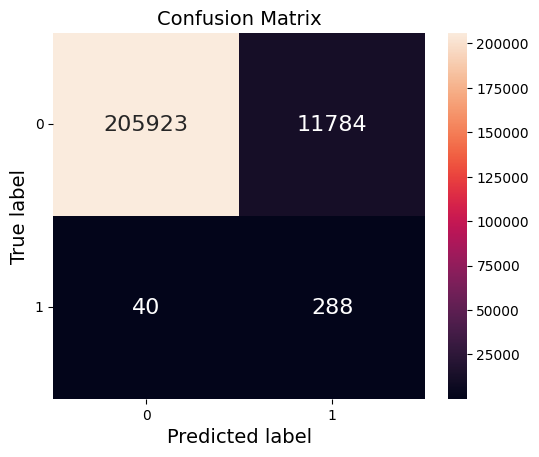

In [138]:
def conf_mat(y_test, y_pred):
    """
    Computes confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      confusion_mat (array): A 2D array representing a 2x2 confusion matrix
    """
    y_test, y_pred = list(y_test), list(y_pred)
    count, labels, confusion_mat = len(y_test), [0, 1], np.zeros(shape = (2, 2), dtype = int)
    for i in range(2):
        for j in range(2):
            confusion_mat[i][j] = len([k for k in range(count) if y_test[k] == labels[i] and y_pred[k] == labels[j]])
    return confusion_mat


def conf_mat_heatmap(y_test, y_pred):
    """
    Prints confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      Nothing, prints a heatmap representing a 2x2 confusion matrix
    """
    confusion_mat = conf_mat(y_test, y_pred)
    labels, confusion_mat_df = [0, 1], pd.DataFrame(confusion_mat, range(2), range(2))
    plt.figure(figsize = (6, 4.75))
    sns.heatmap(confusion_mat_df, annot = True, annot_kws = {"size": 16}, fmt = 'd')
    plt.xticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.yticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.xlabel("Predicted label", fontsize = 14)
    plt.ylabel("True label", fontsize = 14)
    plt.title("Confusion Matrix", fontsize = 14)
    plt.grid(False)
    plt.show()

y_pred = scored_test['is_anomaly'].astype(int)
conf_mat_heatmap(y_test, y_pred)

In [139]:
from sklearn.metrics import roc_auc_score, average_precision_score

auc = roc_auc_score(y_test, scored_test['anomaly_score'])
ap  = average_precision_score(y_test, scored_test['anomaly_score'])

print(f"AUC: {auc:.3f}, AP: {ap:.3f}")


AUC: 0.976, AP: 0.543


In [140]:
scored_test['anomaly_score']

317716     2.475095
587254     3.225830
588404     3.463485
368993     2.387468
968944     3.010803
             ...   
753961     2.025156
94456      2.323968
1055803    2.342491
34249      2.369321
1065385    2.617548
Name: anomaly_score, Length: 218035, dtype: float64